# Preliminaries 

The `all-the-news` dataset is really quite nice and has a **TON** of data, this is actually a problem. We address this and other issues in this notebook: 

* We trim the dataset down from 2.1M rows to a much more manageable 150k rows 
* We filter out the 10% longest and 10% shortest articles (These are usually either transcripts or had a scraping error)
* Also we remove Chinese (some of the articles are non English)
* We assign a train test split that is representative of each publication 
* We remove some words that would be considered cheating like publication names, author names, and urls. If we are just learning to recognize keywords from a source like "NYT" or nyt.com in the body of an article - we aren't actually learning anything beyond a rule based approach! 

#### 1.) Downsize the data

In [1]:
import polars as pl
import random
import re 
import spacy
from tqdm import tqdm

In [2]:
# Load the dataset
df = pl.read_csv("all-the-news-2-1-LARGE.csv")

In [3]:
# Define target sources and their desired counts
target_counts = {
    "The New York Times": 10000,
    "The Hill": 10000,
    "Reuters": 10000,
    "People": 10000,
    "CNN": 10000,
    "Vice": 10000,
    "Politico": 10000,
    "Buzzfeed News": 10000,
    "Economist": 10000,
    "Fox News": 10000,
}

# Filter to only target sources
df = df.filter(pl.col("publication").is_in(list(target_counts.keys())))

# remove articles with length 0 or null 
df = df.filter(pl.col("article").is_not_null())

lower_bound = 800
upper_bound = 6000

# Filter based on these quantiles
df = df.with_columns([
    pl.col("article").str.len_chars().alias("article_length")
]).filter(
    (pl.col("article_length") > lower_bound) & (pl.col("article_length") < upper_bound)
).drop("article_length")

#### 1b.) Quick fix to remove Chinese 

In [4]:
# Remove any article with Chinese characters in the title 
df = df.filter(~pl.col("title").str.contains(r"[\u4e00-\u9fff]"))

In [5]:
# Downsample by longest articles for each publication
filtered_parts = []

for pub, target_size in target_counts.items():
    pub_df = (
        df.filter(pl.col("publication") == pub)
          .head(target_size)
    )
    filtered_parts.append(pub_df)

# Combine all filtered parts
trimmed_df = pl.concat(filtered_parts)

# Group and count by publication
final_counts = (
    trimmed_df.group_by("publication")
              .count()
              .sort("count", descending=True)
)

# Print results
print(final_counts)

shape: (10, 2)
┌────────────────────┬───────┐
│ publication        ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ The Hill           ┆ 10000 │
│ The New York Times ┆ 10000 │
│ Buzzfeed News      ┆ 10000 │
│ Reuters            ┆ 10000 │
│ CNN                ┆ 10000 │
│ Economist          ┆ 10000 │
│ Vice               ┆ 10000 │
│ Fox News           ┆ 10000 │
│ People             ┆ 10000 │
│ Politico           ┆ 10000 │
└────────────────────┴───────┘


/var/folders/kr/nlrwk4z12mj5x_srmfby65p40000gn/T/ipykernel_5528/785617648.py:17: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


#### 2.) Split into train and test segments

In [6]:
import polars as pl
import numpy as np

random_state = 42
np.random.seed(random_state)

def assign_splits(group: pl.DataFrame) -> pl.DataFrame:
    n = len(group)
    indices = np.random.permutation(n)  # Shuffle indices
    split = np.where(indices < 1000, "test", "train")  # Assign first 1k as test
    return group.with_columns(pl.Series("split", split))

# Apply to each group
trimmed_df = (
    trimmed_df
    .group_by("publication", maintain_order=True)
    .map_groups(assign_splits)
)

In [7]:
print(
    trimmed_df
    .group_by("publication", "split")
    .agg(pl.count())
    .sort("publication", "split")
)

shape: (20, 3)
┌────────────────────┬───────┬───────┐
│ publication        ┆ split ┆ count │
│ ---                ┆ ---   ┆ ---   │
│ str                ┆ str   ┆ u32   │
╞════════════════════╪═══════╪═══════╡
│ Buzzfeed News      ┆ test  ┆ 1000  │
│ Buzzfeed News      ┆ train ┆ 9000  │
│ CNN                ┆ test  ┆ 1000  │
│ CNN                ┆ train ┆ 9000  │
│ Economist          ┆ test  ┆ 1000  │
│ …                  ┆ …     ┆ …     │
│ The Hill           ┆ train ┆ 9000  │
│ The New York Times ┆ test  ┆ 1000  │
│ The New York Times ┆ train ┆ 9000  │
│ Vice               ┆ test  ┆ 1000  │
│ Vice               ┆ train ┆ 9000  │
└────────────────────┴───────┴───────┘


/var/folders/kr/nlrwk4z12mj5x_srmfby65p40000gn/T/ipykernel_5528/167683159.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count())


In [8]:
trimmed_df.write_csv("all-the-news-2-1-SMALL.csv")

#### 3.) Clean the data

In [9]:
import re, unicodedata, polars as pl
from tqdm.auto import tqdm

# ---------------------------------------------------------------------
# 1.  publisher aliases (unchanged)
# ---------------------------------------------------------------------
PUB_ALIASES = {
    "Buzzfeed News": [
        "Buzzfeed News", "BuzzFeed News",
        "BuzzFeed.com",  "Buzzfeed.com", "BuzzFeed"
    ],
    "Fox News": ["Fox News", "FoxNews.com", "Fox"],
    "CNN": ["CNN", "Cable News Network", "CNNEspanol", "CNNOpinion"],
    "Reuters": ["Reuters", "Reuters.com"],
    "Vice": ["VICE", "Vice News", "Vice.com"],
    "The New York Times": [
        "New York Times", "The New York Times", "NYT",
        "The Times", "NYTimes.com", "NY Times"
    ],
    "Politico": ["Politico", "Politico.com"],
    "The Hill": [                       # keep a few stable fragments
        "The Hill", "Capitol Hill Publishing Corp",
        "Capitol Hill Publishing", "TheHill.com"
    ],
    "Economist": ["The Economist", "Economist.com", "Economist", "Upgrade your inbox and get our Daily Dispatch and Editor's Picks"],
    "People":    ["People Magazine", "People", "People.com"]
}

# ---------------------------------------------------------------------
# 2.  build one literal‑safe regex
# ---------------------------------------------------------------------
aliases_escaped = [
    re.escape(a.strip())
    for group in PUB_ALIASES.values()
    for a in group
]

pattern = re.compile(
    r"(?i)(?:\b" + r"\b|\b".join(aliases_escaped) + r")"
    r"(?:['’]s)?"
    r"(?=\b|[^A-Za-z0-9]|$)"
)

def regex_clean(text: str) -> str:
    return pattern.sub("[PUB]", unicodedata.normalize("NFKD", text))

# ---------------------------------------------------------------------
# 2.  rule‑based clean (runs before regex/NER)
# ---------------------------------------------------------------------
def rule_based_clean(text: str, pub: str) -> str:
    if pub == "The Hill":
        text = text[:-230] if len(text) > 230 else ""
    text = text[25:]                          # drop first 25 chars universally
    return text

# ---------------------------------------------------------------------
# 3.  Polars pipeline
#      requires columns "article" & "publication"
# ---------------------------------------------------------------------
progress = tqdm(total=len(trimmed_df), desc="Cleaning", unit="row")

def _clean(row):
    t = rule_based_clean(row["article"], row["publication"])
    t = regex_clean(t)        # mask publishers
    progress.update()
    return t

cleaned_df = trimmed_df.with_columns(
    pl.struct(["article", "publication"]).map_elements(_clean).alias("clean_article")
)

progress.close()

/Users/hunterschep/.pyenv/versions/3.12.5/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Cleaning:   0%|          | 0/100000 [00:00<?, ?row/s]/var/folders/kr/nlrwk4z12mj5x_srmfby65p40000gn/T/ipykernel_5528/3921435850.py:68: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  cleaned_df = trimmed_df.with_columns(
Cleaning: 100%|██████████| 100000/100000 [00:20<00:00, 4804.55row/s]


In [10]:
# ────────────────────────── 4. speed‑up PERSON stripping ──────────────────────────
import spacy, os
from tqdm.auto import tqdm

nlp          = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])
PLACEHOLDER  = "[NAME]"
BATCH_SIZE   = 1_000                    # tune for your RAM/CPU
N_PROC       = min(4, os.cpu_count())   # spaCy workers (0 = single‑process)

def scrub_person(doc) -> str:
    """Replace all PERSON entities with [NAME] in one Doc."""
    if not doc.ents:
        return doc.text
    text, last, out = doc.text, 0, []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            out.append(text[last:ent.start_char])
            out.append(PLACEHOLDER)
            last = ent.end_char
    out.append(text[last:])
    return "".join(out)

# pull the column into Python once
texts   = cleaned_df["clean_article"].to_list()
total   = len(texts)
scrubbed, pbar = [], tqdm(total=total, desc="spaCy PERSON scrub", unit="doc")

# stream texts through nlp.pipe (multi‑proc, batched)
for doc in nlp.pipe(texts, batch_size=BATCH_SIZE, n_process=N_PROC):
    scrubbed.append(scrub_person(doc))
    pbar.update()

pbar.close()

# attach anonymised text back to the DataFrame
cleaned_df = cleaned_df.with_columns(
    pl.Series("anon_article", scrubbed)      # new column; overwrite if you prefer
)

print("Finished: names replaced in", total, "articles")


spaCy PERSON scrub: 100%|██████████| 100000/100000 [22:58<00:00, 72.56doc/s] 


Finished: names replaced in 100000 articles


In [11]:
# Remove URLs
cleaned_df = cleaned_df.with_columns(
    pl.col("clean_article").str.replace_all(r"https?://\S+", "[URL]"),
)

In [12]:
# Step 1: Count how many articles each author appears in
author_counts = (
    cleaned_df
    .group_by("author")
    .agg(pl.count().alias("n_articles"))
    .filter(pl.col("author").is_not_null())
)

# Step 2: Identify authors who only appear in one article
single_use_authors = (
    author_counts
    .filter(pl.col("n_articles") == 1)
    .get_column("author")
    .to_list()
)

# Step 3: Create a mapping of article to its author (for single-use authors only)
author_mapping = (
    cleaned_df
    .select(["clean_article", "author"])
    .filter(pl.col("author").is_in(single_use_authors))
)

# Step 4: Remove only the specific author from their own article
cleaned_df = cleaned_df.with_columns(
    pl.struct(["clean_article", "author"]).map_elements(
        lambda x: x["clean_article"].replace(x["author"], "[AUTHOR]") 
        if x["author"] in single_use_authors 
        else x["clean_article"],
        return_dtype=pl.String
    ).alias("clean_article")
)

/var/folders/kr/nlrwk4z12mj5x_srmfby65p40000gn/T/ipykernel_5528/3536730350.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("n_articles"))


In [13]:
publications = [
    "The New York Times",
    "The Hill",
    "Reuters",
    "People",
    "CNN",
    "Vice",
    "Politico",
    "Buzzfeed News",
    "Economist",
    "Fox News",
]

import textwrap

# how many characters of the article to show when a match is found
SNIPPET_LEN = 100          # set to None to print the whole thing

sample = cleaned_df.sample(5000, seed=)

for pub in publications:
    # literal‑string search, case‑insensitive
    hits = sample.filter(
        pl.col("clean_article").str.contains(pub, literal=True)
    )

    if hits.height:                         # Polars uses .height instead of len()
        print(f"\n⚠️  Found '{pub}' in {hits.height} rows")

        for i, row in enumerate(hits.select("clean_article").to_series()):
            article = row[:SNIPPET_LEN] + "…" if SNIPPET_LEN and len(row) > SNIPPET_LEN else row
            print(textwrap.indent(f"[{i+1}] {article}", prefix="    "))



SyntaxError: expected argument value expression (3743903350.py, line 19)

#### Sanity check - lets look at average article length

In [14]:
avg_length = (
    cleaned_df
    .group_by("publication")
    .agg(
        pl.col("clean_article").str.len_chars().mean().alias("avg_length"),
        pl.col("clean_article").str.len_chars().median().alias("median_length"),
        pl.col("clean_article").str.len_chars().min().alias("min_length"),
        pl.col("clean_article").str.len_chars().max().alias("max_length")
    )
    .sort("avg_length", descending=True)
)
print(avg_length)

shape: (10, 5)
┌────────────────────┬────────────┬───────────────┬────────────┬────────────┐
│ publication        ┆ avg_length ┆ median_length ┆ min_length ┆ max_length │
│ ---                ┆ ---        ┆ ---           ┆ ---        ┆ ---        │
│ str                ┆ f64        ┆ f64           ┆ u32        ┆ u32        │
╞════════════════════╪════════════╪═══════════════╪════════════╪════════════╡
│ Economist          ┆ 3837.8693  ┆ 3853.5        ┆ 706        ┆ 5917       │
│ The New York Times ┆ 3227.5214  ┆ 3122.0        ┆ 766        ┆ 10799      │
│ CNN                ┆ 2998.0659  ┆ 2756.0        ┆ 776        ┆ 5975       │
│ Vice               ┆ 2892.182   ┆ 2661.5        ┆ 775        ┆ 5978       │
│ Buzzfeed News      ┆ 2882.501   ┆ 2700.0        ┆ 771        ┆ 5969       │
│ Politico           ┆ 2857.7932  ┆ 2576.5        ┆ 706        ┆ 5972       │
│ Reuters            ┆ 2810.723   ┆ 2621.0        ┆ 774        ┆ 5973       │
│ The Hill           ┆ 2611.171   ┆ 2201.0       

In [ ]:
# Drop the original article column
cleaned_df = cleaned_df.drop("article")
cleaned_df = cleaned_df.drop("clean_article")
# Rename the anonymized article column
cleaned_df = cleaned_df.rename({"anon_article": "clean_article"})

#### Save our cleaned data! 

In [19]:
# Save the cleaned DataFrame to a CSV file
cleaned_df.write_csv("all-the-news-2-1-SMALL-CLEANED.csv")

#### Data Analysis 

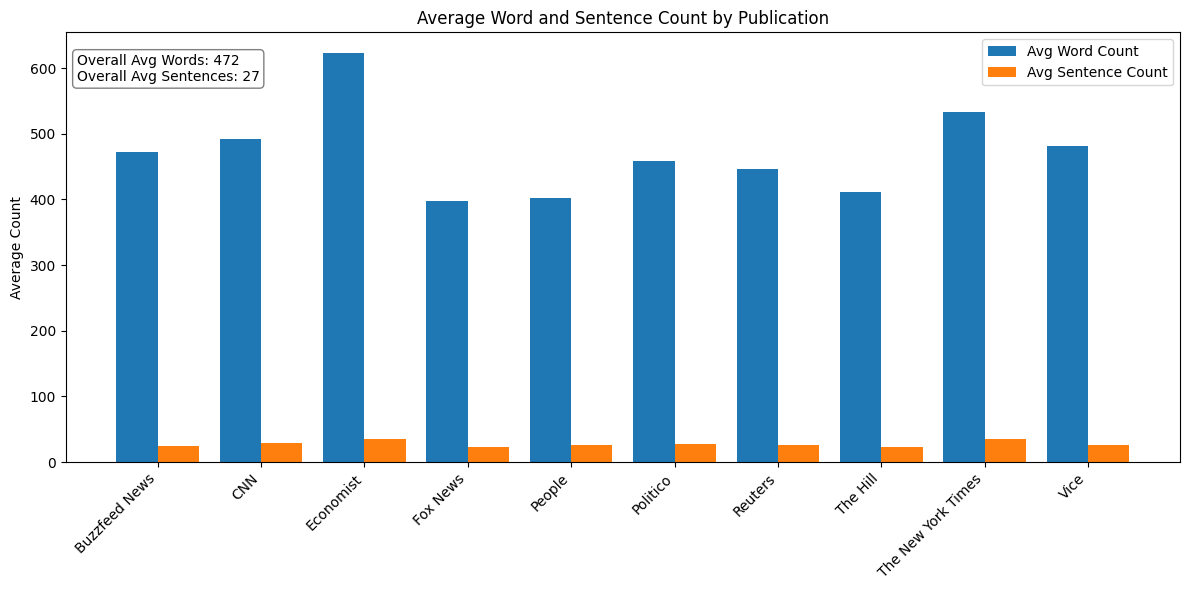

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned data
cleaned_df = pd.read_csv("all-the-news-2-1-SMALL-CLEANED.csv")

# Create word and sentence count columns
cleaned_df["word_count"] = cleaned_df["clean_article"].str.split().apply(len)
cleaned_df["sentence_count"] = cleaned_df["clean_article"].str.count(r"[.!?]")

# Group by publication and calculate average stats
avg_counts = cleaned_df.groupby("publication")[["word_count", "sentence_count"]].mean().reset_index()

# Filter for the 10 publications of interest
selected_pubs = [
    "Buzzfeed News", "CNN", "Economist", "Fox News", "People",
    "Politico", "Reuters", "The Hill", "The New York Times", "Vice"
]
avg_counts = avg_counts[avg_counts["publication"].isin(selected_pubs)]

# Sort to match original order
avg_counts["publication"] = pd.Categorical(avg_counts["publication"], categories=selected_pubs, ordered=True)
avg_counts = avg_counts.sort_values("publication")

# Calculate overall average word and sentence count
overall_avg_words = cleaned_df["word_count"].mean()
overall_avg_sentences = cleaned_df["sentence_count"].mean()

# Plot
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(avg_counts))

plt.bar([i - bar_width/2 for i in x], avg_counts["word_count"], width=bar_width, label="Avg Word Count")
plt.bar([i + bar_width/2 for i in x], avg_counts["sentence_count"], width=bar_width, label="Avg Sentence Count")

plt.xticks(ticks=x, labels=avg_counts["publication"], rotation=45, ha='right')
plt.ylabel("Average Count")
plt.title("Average Word and Sentence Count by Publication")
plt.legend()

# Add overall average text box in top-left corner
plt.text(
    0.01, 0.95,
    f"Overall Avg Words: {overall_avg_words:.0f}\nOverall Avg Sentences: {overall_avg_sentences:.0f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

plt.tight_layout()
plt.show()
